### Code that uploads an image, demages it using a mask (that it also uploads) and than uses PDE method to restore the original image

In [318]:
# %matplotlib widget #If viewed in Jupyter lab
# calling it a second time may prevent some graphics errors
%matplotlib notebook

from PIL import Image
import numpy as np
import sys
from matplotlib import pyplot as plt
# For printing out all the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Upload an image

<IPython.core.display.Javascript object>


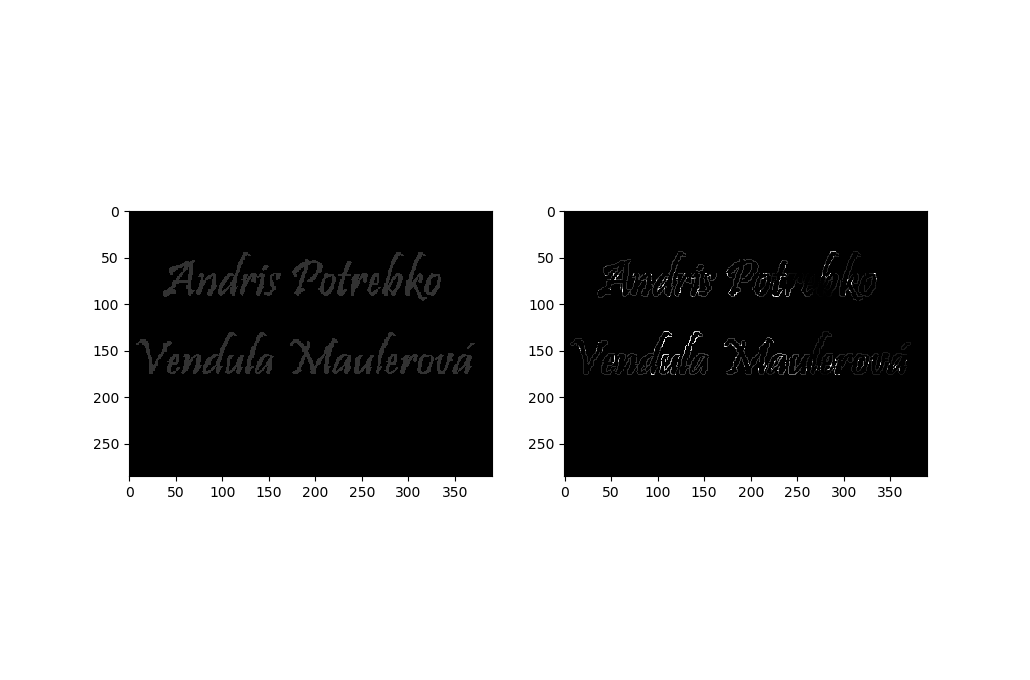

In [319]:
img = Image.open('Pics\serveimage.jpg', mode='r').convert('L')
Mask = Image.open('Pics\TheMask.png', mode='r').convert('L')
#Mask.point(lambda x: 0 if x<128 else 255, '1')
# Does not work saving
# img2=Image.open('Pics\serveimage.jpg',mode='r')
# img2.save("Name.jpg")
# img.close()
I = np.asarray(img).copy()  # Copy so that you can update the file
MaskMat = np.asarray(Mask).copy()

MaskMat[MaskMat < 128] = 0    # Black
MaskMat[MaskMat >= 128] = 255  # White
#plt.imshow(I, cmap='gray', interpolation='nearest');
# plt.savefig('Pics\GrayScale.png')
# img[1,2]
# img2
I2 = I
# I2[MaskMat==1]
# MaskMat==1
# MaskMat[MaskMat==255]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10.3, 6.8)
#plt.imshow(MaskMat, cmap='gray', interpolation='nearest')
I[MaskMat == 0] = 0
# sum(MaskMat==0)+sum(MaskMat==255)
ax1.imshow(I, cmap='gray', interpolation='nearest')

### Define positions of the demaged regions and boundary conditions

In [475]:
from PIL import ImageFilter
#import PIL.ImageOps

# This gives the outer border - where we can take the border conditions
borderInv1 = PIL.ImageOps.invert(Mask).filter(ImageFilter.CONTOUR)
borderInv = np.asarray(borderInv1)

border1 = Mask.filter(ImageFilter.CONTOUR)  # iner border
border = np.asarray(border1)


# Check with the plot above
# I[borderInv == 0] = 255
#
# I[border == 0] = 255
# plt.imshow(I, cmap='gray', interpolation='nearest')

# Another check
# np.max(I[borderInv == 0]) #The value is not 255 which means that it is not the border - black

bc = np.zeros([len(I), len(I[1])])
bc[borderInv == 0] = I[borderInv == 0]
bc[:, [0, -1]] = 0  # Otherwise there are problems at the border of the image
bc[[0, -1], :] = 0
ax2.imshow(bc, cmap='gray')

## Begin the Jecobi method
### Define the initial values for all u inside as the average of the boundary

In [476]:
NIter = 20
InnerPts = np.zeros((NIter, len(I), len(I[0])))  # Inner points at any time

Pts0 = np.array([[-1]*len(I[0])]*len(I))
# InerPts=np.zeros([len(I),len(I[1])])   #[[1]*len(I[1])]*len(I)
Pts0[MaskMat == 0] = np.mean(bc[borderInv == 0])
Pts0[0, 0] = 255  # otherwise you don't see it in the image

# InitVal
ax1.imshow(Pts0, cmap='gray')
InnerPts = np.append([Pts0], InnerPts, axis=0)
#MaskMat[MaskMat == np.mean(bc[borderInv == 0])]

### Define the fuction which will calculate the next step

In [477]:
N2d = 4
NB = 0  # Nr of vonNeuman boundaries


def JacobyMeth(t, j, k, *args):
    # print(j,k)
    # [u11, u21, u12, u22]
    Indx = np.array([[j-1, k], [j+1, k], [j, k-1], [j, k+1]])
    uNeigh = InnerPts[t, Indx[:, 0], Indx[:, 1]]
    for i, indc in enumerate(Indx):
        if bc[indc[0], indc[1]] != 0:
            uNeigh[i] = bc[indc[0], indc[1]]
#         print(bc[indc[0],indc[1]])
    # print(N2d,NB,sum(uNeigh))
    InnerPts[t+1, j, k] = 1/(N2d-NB)*(sum(uNeigh))  # +rho=0

### Run iterations

In [471]:
%%time
for t in range(NIter):
    for j in range(len(InnerPts[0])):
        for k in range(len(InnerPts[0][0])):
            if Pts0[j, k] == -1:
                continue
            JacobyMeth(t, j, k)

Wall time: 16.6 s


In [472]:
[j, k] = [0, 0]
# [u11, u21, u12, u22]
Indx = np.array([[j-1, k], [j+1, k], [j, k-1], [j, k+1]])
# uNeigh = [InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]]
# NB=0  #Nr of boundary sites
# for i ,indc in enumerate(Indx):
#     print(indc)
#     if bc[indc[0],indc[1]] != 0:
#         print(bc[indc[0],indc[1]])
#         uNeigh[i] = bc[indc[0], indc[1]]
#         NB+=1

In [473]:
len(InnerPts[0])
len(Pts0)

285

285

### Plot the result

<IPython.core.display.Javascript object>


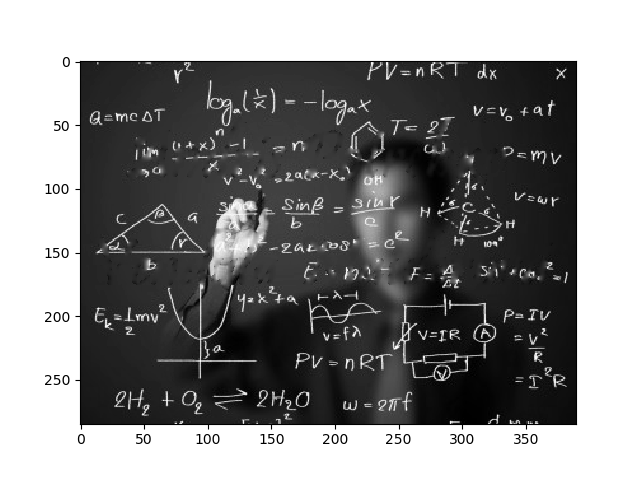

In [474]:
ResImag=I
ResImag[MaskMat == 0] = InnerPts[NIter][MaskMat == 0] 
fig2, ax3 = plt.subplots()
ax3.imshow(ResImag, cmap='gray', interpolation='nearest')

In [459]:
[j,k]=[138, 177]
Pts0[138,177-2:184]
#bc[j-2]
Pts0[j,k]

array([-1, 48, 48, 48, 48, 48, 48, 48, -1])

48

In [462]:
(bc[j-1,k] + Pts0[j,k-1] + Pts0[j,k+1] + Pts0[j+1,k])/4
InnerPts[1,j,k]

52.5

52.5

This is for my git

In [79]:
#! git remote add origin https://github.com/AndrissP/ImageRestore.git   
#! git push --set-upstream origin master
#! git status

Branch 'master' set up to track remote branch 'master' from 'origin'.


To https://github.com/AndrissP/ImageRestore.git
   45b996a..a7635b6  master -> master


In [80]:
### The link in the description does not work. It is scipy.fftpack that does not load
#from scipy.fftpack import fft

# import skimage.io
# import numpy as np
# import skimage.viewer
# from matplotlib import pyplot as plt
# import sys